In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.saving import register_keras_serializable
import matplotlib.pyplot as plt
from glob import glob
import cv2
from IPython.core.display import display, HTML

C:\Users\HP\AppData\Local\Temp\ipykernel_11504\967657653.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", len(tf.config.list_physical_devices('GPU')) > 0)

TensorFlow version: 2.18.0
GPU Available:  False


In [3]:
def load_image_pair(blur_path, sharp_path, target_size=(256,256)):
    # Read images
    blur_img = tf.io.read_file(blur_path)
    sharp_img = tf.io.read_file(sharp_path)
    
    # Decode images
    blur_img = tf.image.decode_png(blur_img, channels=3)
    sharp_img = tf.image.decode_png(sharp_img, channels=3)
    
    # Calculate resize scale while maintaining aspect ratio
    def resize_with_aspect_ratio(image, target_size):
        # Convert to float to avoid integer division
        height = tf.cast(tf.shape(image)[0], tf.float32)
        width = tf.cast(tf.shape(image)[1], tf.float32)
        
        # Determine scaling factor
        scale = target_size / tf.maximum(height, width)
        
        # Calculate new dimensions
        new_height = tf.cast(height * scale, tf.int32)
        new_width = tf.cast(width * scale, tf.int32)
        
        # Resize image
        return tf.image.resize(image, [new_height, new_width], method=tf.image.ResizeMethod.BILINEAR)
    
    # Resize both images
    blur_img = resize_with_aspect_ratio(blur_img, max(target_size))
    sharp_img = resize_with_aspect_ratio(sharp_img, max(target_size))

    blur_img = tf.image.resize_with_crop_or_pad(blur_img, target_size[0], target_size[1])
    sharp_img = tf.image.resize_with_crop_or_pad(sharp_img, target_size[0], target_size[1])
    
    # Normalize to [0, 1]
    blur_img = tf.cast(blur_img, tf.float32) / 255.0
    sharp_img = tf.cast(sharp_img, tf.float32) / 255.0
    
    return blur_img, sharp_img

#### Line 1: dataset = tf.data.Dataset.from_tensor_slices((blur_paths, sharp_paths))
This line creates the foundation of the TensorFlow dataset pipeline:

What's happening internally:

TensorFlow takes the two lists (blur_paths and sharp_paths) and "slices" them element-wise
It creates a dataset where each element is a tuple of corresponding elements from these lists
No data loading happens yet - just setting up the structure

Memory footprint:

Only the paths themselves are stored in memory, not the image content
For 1000 image pairs, this might only consume a few KB of memory for the path strings

Technical details:

The shape of each element is ((), ()) - two scalar string tensors
Example element: ('/path/to/blur/img1.png', '/path/to/sharp/img1.png')
TensorFlow's internal representation creates tensors from these lists and tracks how to slice them

Why it's useful:

Creates paired data without duplicating the paths in memory
Maintains the exact correspondence between blur and sharp images
Sets up for future transformations to be applied element-wise

#### Line 2: dataset = dataset.map(lambda x, y: load_image_pair(x, y, img_size), num_parallel_calls=tf.data.AUTOTUNE)
This line defines how to transform the path data into actual image data:

What's happening internally:

The .map() method registers a transformation function to apply to each element
The transformation is specified as a lambda function that calls load_image_pair
The function is not executed yet - just registered for future execution

The transformation function:

lambda x, y: load_image_pair(x, y, img_size) unpacks each tuple into x (blur path) and y (sharp path)
When executed, it will call the load_image_pair function with these parameters
The function does the actual work of loading files, decoding PNGs, resizing, and normalizing

Parallelism configuration:

num_parallel_calls=tf.data.AUTOTUNE tells TensorFlow to run multiple instances of this function in parallel
tf.data.AUTOTUNE lets TensorFlow dynamically determine the optimal number of parallel operations
On an 8-core CPU, up to 8 images might be loaded simultaneously
This significantly speeds up data processing, especially for I/O-bound operations like file loading

Execution model:

The transformation is only applied when data is requested (lazy evaluation)
TensorFlow builds an execution graph that optimizes this operation

#### Line 3: dataset = dataset.batch(batch_size)
This line groups individual examples into batches:

What's happening internally:

Creates a new dataset that combines consecutive elements into batches
Each new element becomes a batch of batch_size examples
The tensors for each example are stacked along a new first dimension

Technical details:

If individual examples were shape [256, 256, 3] (height, width, channels)
After batching, they become [batch_size, 256, 256, 3]
TensorFlow handles partial batches at the end of the dataset (if dataset size isn't divisible by batch_size)

Memory implications:

Only batch_size images are loaded into memory at a time
For a batch size of 16 with 256×256 RGB images:

Approx. memory usage: 16 × 256 × 256 × 3 × 4 bytes ≈ 12.5 MB per batch

This is far more memory-efficient than loading the entire dataset

Performance implications:

Modern GPUs process batches of data more efficiently than single examples
Batching reduces the overhead of sending data to the GPU
It enables matrix operations that process multiple examples in parallel

#### Line 4: dataset = dataset.prefetch(tf.data.AUTOTUNE)
This line implements a crucial performance optimization:

What's happening internally:

Creates a buffer that prefetches elements from the input dataset
While the model is training on batch N, the data pipeline prepares batch N+1
Eliminates waiting time between batches

Technical details:

tf.data.AUTOTUNE tells TensorFlow to determine the optimal buffer size dynamically
It adapts to the speed of consumption and production of data
Typically maintains 1-2 batches in memory ahead of what's currently being processed

Performance impact:

Without prefetching: CPU prepares batch → GPU processes batch → CPU prepares next batch → etc.
With prefetching: CPU prepares batch 1 → GPU processes batch 1 while CPU prepares batch 2 → etc.
This can improve training speed by 30-50% in I/O-bound scenarios

Memory considerations:

Requires additional memory to hold the prefetched batches
The memory overhead is proportional to the batch size
The extra memory usage is worthwhile for the performance gain

#### Line 5: return dataset
This simply returns the fully configured dataset pipeline that incorporates all the optimizations and transformations.
Overall Data Flow:
Visualizing the entire process for a single step during training:

TensorFlow requests the next batch from the dataset
If a prefetched batch is available, it's returned immediately
In parallel, paths for the next batch are taken from the dataset
For each path pair in that next batch:

Multiple worker threads (determined by AUTOTUNE) load and process images simultaneously
Each thread reads image files, decodes, resizes, and normalizes


The processed images are stacked into a batch
This batch is placed in the prefetch buffer, ready for the next request

This entire pipeline is designed to minimize waiting time and maximize GPU utilization during training, while keeping memory usage manageable even for large datasets.

In [11]:
def create_dataset(blur_paths, sharp_paths, batch_size):
    """
    Create a TensorFlow dataset from image paths.
    This dataset is better than converting the data into numpy arrays,
    because it calls and encode the data(images) on demand instead of
    loading the whole data on the memory like numpy arrays do, and this
    gives us the memory efficiency that we need in our real-world project.
    """
    dataset = tf.data.Dataset.from_tensor_slices((blur_paths, sharp_paths))
    dataset = dataset.map(lambda x, y: load_image_pair(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [13]:
def preprocess_paths(data_dir, batch_size = 8):
    blur_paths = []
    sharp_paths = []
    
    for folder in os.listdir(data_dir):
        path = os.path.join(data_dir, folder)
        if not os.path.isdir(path):
            continue

        # Get blur and sharp directories
        sh = os.path.join(path, 'sharp')
        
        blur_dir = os.path.join(path, 'blur')
        sharp_dir = sh if os.path.exists(sh) else os.path.join(path, 'gt')
        
        # Get image files
        if sharp_dir == sh:      # For GoPro dataset
            blur_images = sorted(os.listdir(blur_dir))
            sharp_images = sorted(os.listdir(sharp_dir))
        else: # For RealBlur dataset
            def split(path):
                text = os.path.splitext(path)[0]
                return int(text[text.find("_")+1 : ])
                
            blur_images = sorted(os.listdir(blur_dir), key=split)
            sharp_images = sorted(os.listdir(sharp_dir), key=split)
        
        # Add full paths
        for blur_img, sharp_img in zip(blur_images, sharp_images): # zip aggregates two lists like [(000280, 000280), (000281, 000281)]
            blur_paths.append(os.path.join(blur_dir, blur_img))
            sharp_paths.append(os.path.join(sharp_dir, sharp_img))

    return blur_paths, sharp_paths

In [15]:
GoPro_train = r"C:\Users\HP\Documents\GOPRO_Large\train"
GoPro_test = r"C:\Users\HP\Documents\GOPRO_Large\test"
RealBlur_train = r"C:\Users\HP\Documents\RealBlur\RealBlur-J\train"
RealBlur_test = r"C:\Users\HP\Documents\RealBlur\RealBlur-J\test"

# Train Data Processing
Go_blur_train, Go_sharp_train = preprocess_paths(GoPro_train)
Real_blur_train, Real_sharp_train = preprocess_paths(RealBlur_train)

full_blur_tr = Go_blur_train + Real_blur_train
full_sharp_tr = Go_sharp_train + Real_sharp_train

for i in range(5):
    print("Blur:", full_blur_tr[i])
    print("Sharp:", full_sharp_tr[i])
    print("-" * 40)
    
# Test Data Prorcessing
Go_blur_test, Go_sharp_test = preprocess_paths(GoPro_test)
Real_blur_test, Real_sharp_test = preprocess_paths(RealBlur_test)

full_blur_te = Go_blur_test + Real_blur_test
full_sharp_te = Go_sharp_test + Real_sharp_test

for i in range(5):
    print("Blur:", full_blur_te[-i])
    print("Sharp:", full_sharp_te[-i])
    print("-" * 40)
    
train_dataset = create_dataset(full_blur_tr, full_sharp_tr, 8)
test_dataset = create_dataset(full_blur_te, full_sharp_te, 8)
print(train_dataset.element_spec)
print(test_dataset.element_spec)

Blur: C:\Users\HP\Documents\GOPRO_Large\train\GOPR0372_07_00\blur\000047.png
Sharp: C:\Users\HP\Documents\GOPRO_Large\train\GOPR0372_07_00\sharp\000047.png
----------------------------------------
Blur: C:\Users\HP\Documents\GOPRO_Large\train\GOPR0372_07_00\blur\000048.png
Sharp: C:\Users\HP\Documents\GOPRO_Large\train\GOPR0372_07_00\sharp\000048.png
----------------------------------------
Blur: C:\Users\HP\Documents\GOPRO_Large\train\GOPR0372_07_00\blur\000049.png
Sharp: C:\Users\HP\Documents\GOPRO_Large\train\GOPR0372_07_00\sharp\000049.png
----------------------------------------
Blur: C:\Users\HP\Documents\GOPRO_Large\train\GOPR0372_07_00\blur\000050.png
Sharp: C:\Users\HP\Documents\GOPRO_Large\train\GOPR0372_07_00\sharp\000050.png
----------------------------------------
Blur: C:\Users\HP\Documents\GOPRO_Large\train\GOPR0372_07_00\blur\000051.png
Sharp: C:\Users\HP\Documents\GOPRO_Large\train\GOPR0372_07_00\sharp\000051.png
----------------------------------------
Blur: C:\Users\

In [ ]:
# OLD CODE
class Old(Model):
    def __init__(self):
        super().__init__()

        # Encoder Layers
        self.Encoder = Sequential([
        
        Conv2D(64, 3, padding='same', activation='relu'),
        Dropout(0.3),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(3),
        
        Conv2D(128, 3, padding='same', activation='relu'),
        Dropout(0.3),
        Conv2D(128, 3, padding='same', activation='relu'),
        MaxPooling2D(3),
        
        Conv2D(256, 3, padding='same', activation='relu'),
        Dropout(0.3),
        Conv2D(256, 3, padding='same', activation='relu'),
        MaxPooling2D(3),
        
        Conv2D(512, 3, padding='same', activation='relu'),
        ])

        # Decoder layers
        self.Decoder = Sequential([
        Conv2D(512, 3, padding='same', activation='relu'),
    
        UpSampling2D(3),
        Conv2D(256, 3, padding='same', activation='relu'),
        Conv2D(256, 3, padding='same', activation='relu'),
        
        UpSampling2D(3),
        Conv2D(128, 3, padding='same', activation='relu'),
        Conv2D(128, 3, padding='same', activation='relu'),
        
        UpSampling2D(3),
        Conv2D(64, 3, padding='same', activation='relu'),
        Conv2D(64, 3, padding='same', activation='relu'),

        # Output layer
        Conv2D(3, 3, padding='same', activation='sigmoid')
        ])

    def call(self, inputs):
        x = self.Encoder(inputs)
        x = self.Decoder(x)
        return x    

In [6]:
# ADVANCED CODE USING RESIDUAL CONNECTIONS
@register_keras_serializable()
class DeblurAutoencoder(Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        " ENCODER LAYERS "
        # Block 1
        self.enc_conv1_1 = Conv2D(32, 3, padding='same')
        self.enc_act1_1 = ReLU()
        self.enc_drop1 = Dropout(0.2)
        self.enc_conv1_2 = Conv2D(64, 3, padding='same')
        self.enc_act1_2 = ReLU()
        self.enc_pool1 = MaxPooling2D(2)

        # Block 2
        self.enc_conv2_1 = Conv2D(64, 3, padding='same')
        self.enc_act2_1 = ReLU()
        self.enc_drop2 = Dropout(0.2)
        self.enc_conv2_2 = Conv2D(128, 3, padding='same')
        self.enc_act2_2 = ReLU()
        self.enc_pool2 = MaxPooling2D(2)

        # Block 3
        self.enc_conv3_1 = Conv2D(128, 3, padding='same')
        self.enc_act3_1 = ReLU()
        self.enc_drop3 = Dropout(0.2)
        self.enc_conv3_2 = Conv2D(256, 3, padding='same')
        self.enc_act3_2 = ReLU()
        self.enc_pool3 = MaxPooling2D(2)

        #--------------------------------------------
        " Bottleneck "
        self.bottleneck = Conv2D(512, 3, padding='same')
        self.bottleneck_act = LeakyReLU(negative_slope=0.1)
        #--------------------------------------------

        " DECODER LAYERS "
        # Block 3
        self.dec_deconv3 = Conv2DTranspose(256, 3, strides=2, padding='same')
        self.dec_act3_1 = ReLU()
        self.dec_conv3_2 = Conv2D(128, 3, padding='same')
        self.dec_act3_2 = ReLU()

        # Block 2
        self.dec_deconv2 = Conv2DTranspose(128, 3, strides=2, padding='same')
        self.dec_act2_1 = ReLU()
        self.dec_conv2_2 = Conv2D(64, 3, padding='same')
        self.dec_act2_2 = ReLU()

        # Block 1
        self.dec_deconv1 = Conv2DTranspose(64, 3, strides=2, padding='same')
        self.dec_act1_1 = ReLU()
        self.dec_conv1_2 = Conv2D(32, 3, padding='same')
        self.dec_act1_2 = ReLU()

        # Output layer
        self.output_layer = Conv2D(3, 3, padding='same', activation='sigmoid')

    def call(self, inputs):
        # Encoder
        x = self.enc_conv1_1(inputs)
        x = self.enc_act1_1(x)
        x = self.enc_drop1(x)
        x = self.enc_conv1_2(x)
        x = self.enc_act1_2(x)
        skip1 = x
        x = self.enc_pool1(x)

        x = self.enc_conv2_1(x)
        x = self.enc_act2_1(x)
        x = self.enc_drop2(x)
        x = self.enc_conv2_2(x)
        x = self.enc_act2_2(x)
        skip2 = x
        x = self.enc_pool2(x)

        x = self.enc_conv3_1(x)
        x = self.enc_act3_1(x)
        x = self.enc_drop3(x)
        x = self.enc_conv3_2(x)
        x = self.enc_act3_2(x)
        skip3 = x
        x = self.enc_pool3(x)

        # Bottleneck
        x = self.bottleneck(x)
        x = self.bottleneck_act(x)

        # Decoder Block 3
        x = self.dec_deconv3(x)
        skip3_resized = tf.image.resize(skip3, tf.shape(x)[1:3], method='bilinear')
        x = tf.concat([x, skip3_resized], axis=-1)
        x = self.dec_act3_1(x)
        x = self.dec_conv3_2(x)
        x = self.dec_act3_2(x)

        # Decoder Block 2
        x = self.dec_deconv2(x)
        skip2_resized = tf.image.resize(skip2, tf.shape(x)[1:3], method='bilinear')
        x = tf.concat([x, skip2_resized], axis=-1)
        x = self.dec_act2_1(x)
        x = self.dec_conv2_2(x)
        x = self.dec_act2_2(x)

        # Decoder Block 1
        x = self.dec_deconv1(x)
        skip1_resized = tf.image.resize(skip1, tf.shape(x)[1:3], method='bilinear')
        x = tf.concat([x, skip1_resized], axis=-1)
        x = self.dec_act1_1(x)
        x = self.dec_conv1_2(x)
        x = self.dec_act1_2(x)

        return self.output_layer(x)
    # for serializing
    def get_config(self):
        # Return the base configuration
        config = super().get_config()
        return config
    
    @classmethod
    def from_config(cls, config):
        # Create instance with the config
        return cls(**config)

In [10]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(None, None, 3))
vgg.trainable = False
percep_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)

@register_keras_serializable()
def perceptual_loss(y_true, y_pred):
    true_features = percep_model(y_true)
    pred_features = percep_model(y_pred)
    return tf.reduce_mean(tf.abs(true_features - pred_features))

@register_keras_serializable()
def combined_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    perceptual = perceptual_loss(y_true, y_pred)
    return mse_loss + 0.2 * perceptual  # You can tune this weight

### PSNR computes the Peak Signal-to-Noise Ratio (PSNR) between the ground truth (y_true) and the model's predicted (y_pred) images.

#### y_true and y_pred
These are the true and predicted images.
They are typically tensors with pixel values in the range [0,1].
#### Using tf.image.psnr
This is a built-in TensorFlow function that computes PSNR.
max_val=1.0 means pixel values range from 0 to 1 (which is common when normalizing images).

The formula for PSNR is:

<img src="C:\Users\HP\OneDrive\الصور\Screenshots\Screenshot 2025-03-01 140610.png" width="200">

MAX: the highest possible pixel value (1.0 in this case).

<img src="C:\Users\HP\OneDrive\الصور\Screenshots\Screenshot 2025-03-01 140619.png" width="200">

MSE: (Mean Squared Error) the average squared difference between y_true and y_pred:

PSNR is widely used in image processing to measure the quality of a reconstructed or restored image.
Higher PSNR (e.g., 30-50 dB) means better quality (closer to ground truth).
Lower PSNR (e.g., <20 dB) means poor quality (significant distortion).

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', psnr]
)

This tracks PSNR during training, helping you see how well the model is restoring sharp images. Since you monitor val_psnr in ModelCheckpoint, the best model is saved based on PSNR improvement.

PSNR is a great metric for your deblurring autoencoder.
However, PSNR does not always match human perception, so you might consider also using SSIM (Structural Similarity Index).

In [12]:
@register_keras_serializable()
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

@register_keras_serializable()
def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

@register_keras_serializable()
class PSNRMetric(tf.keras.metrics.MeanMetricWrapper):
    def __init__(self, name='psnr', **kwargs):
        super().__init__(psnr, name=name, **kwargs)
    
    def get_config(self):
        # Get the base configuration but exclude 'fn' since it's handled automatically
        config = super().get_config()
        # Remove 'fn' from config to avoid duplication during deserialization
        config.pop('fn', None)
        return config
    
    @classmethod
    def from_config(cls, config):
        # Don't pass 'fn' in config - it will be set automatically by the constructor
        config = config.copy()  # Don't modify the original config
        config.pop('fn', None)  # Remove fn if it exists
        return cls(**config)

@register_keras_serializable()
class SSIMMetric(tf.keras.metrics.MeanMetricWrapper):
    def __init__(self, name='ssim', **kwargs):
        super().__init__(ssim, name=name, **kwargs)
    
    def get_config(self):
        # Get the base configuration but exclude 'fn' since it's handled automatically
        config = super().get_config()
        # Remove 'fn' from config to avoid duplication during deserialization
        config.pop('fn', None)
        return config
    
    @classmethod
    def from_config(cls, config):
        # Don't pass 'fn' in config - it will be set automatically by the constructor
        config = config.copy()  # Don't modify the original config
        config.pop('fn', None)  # Remove fn if it exists
        return cls(**config)

In [21]:
model = DeblurAutoencoder()
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=combined_loss,
    metrics=[PSNRMetric(), SSIMMetric()]
)
model.summary()

NameError: name 'DeblurAutoencoder' is not defined

In [29]:
checkpoint = ModelCheckpoint(
    'Deblurring_Model.keras',
    monitor='val_psnr',
    save_weights_only=False,
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_psnr',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,
    callbacks=[checkpoint, reduce_lr]
) 

Epoch 1/50
754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.1816 - psnr: 23.5718 - ssim: 0.7487
Epoch 1: val_psnr improved from -inf to 26.01960, saving model to Deblurring_Model.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 5184s 7s/step - loss: 0.1815 - psnr: 23.5740 - ssim: 0.7487 - val_loss: 0.1206 - val_psnr: 26.0196 - val_ssim: 0.7158 - learning_rate: 0.0010
Epoch 2/50
754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.1329 - psnr: 26.2468 - ssim: 0.8302
Epoch 2: val_psnr did not improve from 26.01960
754/754 ━━━━━━━━━━━━━━━━━━━━ 4943s 7s/step - loss: 0.1329 - psnr: 26.2471 - ssim: 0.8302 - val_loss: 0.1217 - val_psnr: 25.6722 - val_ssim: 0.7414 - learning_rate: 0.0010
Epoch 3/50
754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.1320 - psnr: 26.3280 - ssim: 0.8350
Epoch 3: val_psnr improved from 26.01960 to 26.32323, saving model to Deblurring_Model.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 4842s 6s/step - loss: 0.1320 - psnr: 26.3283 - ssim: 0.8350 - val_loss: 0.1209 - val_psnr: 26.3232 - val_ssi

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Deblurred image min: 0.0014874436 max: 0.9525995


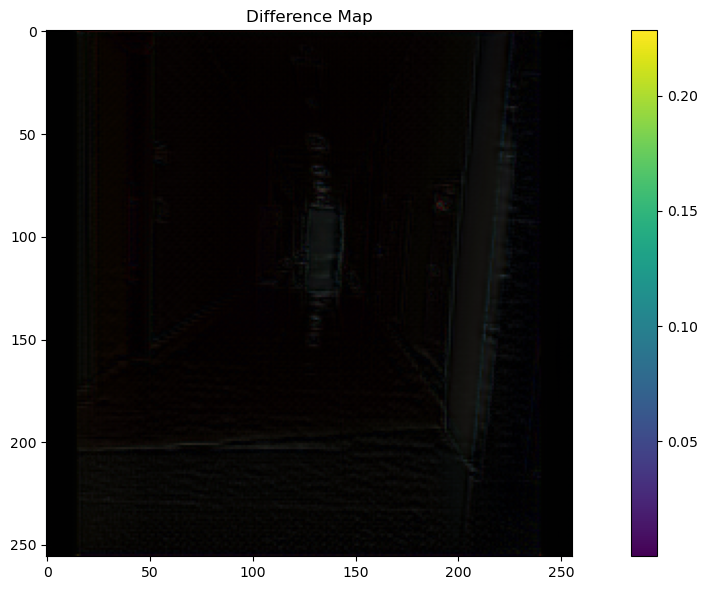

In [113]:
def load_and_preprocess_image(image_path, max_size=256):
    # Read image
    img = tf.io.read_file(image_path)
    
    # Decode image
    img = tf.image.decode_png(img, channels=3)
    if img.shape[-1] == 4:  # Remove alpha channel if present
        img = img[:, :, :3]
    
    # Resize image with aspect ratio preservation
    height = tf.cast(tf.shape(img)[0], tf.float32)
    width = tf.cast(tf.shape(img)[1], tf.float32)
    
    # Determine scaling factor
    scale = max_size / tf.maximum(height, width)
    
    # Calculate new dimensions
    new_height = tf.cast(height * scale, tf.int32)
    new_width = tf.cast(width * scale, tf.int32)
    
    # Resize image
    img = tf.image.resize(img, [new_height, new_width], 
                          method=tf.image.ResizeMethod.BILINEAR)

    img = tf.image.resize_with_crop_or_pad(img, 256, 256)
    
    # Normalize to [0, 1]
    img = tf.cast(img, tf.float32) / 255.0
    
    # Add batch dimension
    img = tf.expand_dims(img, 0)
    
    return img, new_height, new_width

def deblur_image(image_path, max_size=256):
    # Load and preprocess the image
    img_tensor, height, width = load_and_preprocess_image(image_path, max_size)
    
    # Generate the deblurred image
    deblurred_tensor = model.predict(img_tensor)
    
    # Convert tensors to numpy arrays and squeeze batch dimension
    original_img = tf.squeeze(img_tensor).numpy()
    deblurred_img = tf.squeeze(deblurred_tensor).numpy()
    
    # Clip values to valid range [0, 1]
    deblurred_img = np.clip(deblurred_img, 0, 1)
    print("Deblurred image min:", deblurred_img.min(), "max:", deblurred_img.max())
    
    # Show results if requested
    plt.figure(figsize=(12, 6))
    
    # plt.subplot(1, 2, 1)
    # plt.imshow(original_img)
    # plt.title('Blurred Input')
    # plt.axis('off')
    
    # plt.subplot(1, 2, 2)
    # plt.imshow(deblurred_img)
    # plt.title('Deblurred Output')
    # plt.axis('off')
    
    diff = np.abs(original_img - deblurred_img)
    plt.subplot(1, 1, 1)
    plt.imshow(diff)
    plt.title("Difference Map")
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()
    
# Example usage
blurry_image_path = r"C:\Users\HP\Documents\RealBlur\RealBlur-J\test\scene003\blur\blur_2.png"
deblur_image(blurry_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


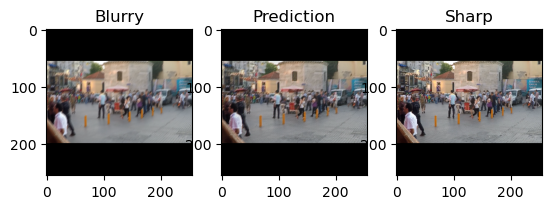

In [115]:
for blurry, sharp in test_dataset.take(1):
    pred = model.predict(blurry)
    plt.subplot(1, 3, 1)
    plt.title("Blurry")
    plt.imshow(blurry[0])
    plt.subplot(1, 3, 2)
    plt.title("Prediction")
    plt.imshow(pred[0])
    plt.subplot(1, 3, 3)
    plt.title("Sharp")
    plt.imshow(sharp[0])


In [33]:
trainSession2nd = load_model('Deblurring_Model.keras')

checkpoint = ModelCheckpoint(
    'Deblurring_Model_2.keras',
    monitor='val_psnr',
    save_weights_only=False,
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_psnr',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

history_continued = trainSession2nd.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    initial_epoch=11,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 12/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.1244 - psnr: 27.0809 - ssim: 0.8488
Epoch 12: val_psnr improved from -inf to 27.32096, saving model to Deblurring_Model_2.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 5008s 7s/step - loss: 0.1244 - psnr: 27.0814 - ssim: 0.8487 - val_loss: 0.1116 - val_psnr: 27.3210 - val_ssim: 0.7594 - learning_rate: 2.5000e-04
Epoch 13/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.1229 - psnr: 27.1179 - ssim: 0.8449
Epoch 13: val_psnr improved from 27.32096 to 27.48744, saving model to Deblurring_Model_2.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 4949s 7s/step - loss: 0.1229 - psnr: 27.1183 - ssim: 0.8449 - val_loss: 0.1109 - val_psnr: 27.4874 - val_ssim: 0.7618 - learning_rate: 2.5000e-04
Epoch 14/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.1219 - psnr: 27.1535 - ssim: 0.8461
Epoch 14: val_psnr improved from 27.48744 to 27.73260, saving model to Deblurring_Model_2.keras

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.000125000005937

KeyboardInterrupt: 

In [35]:
trainSession3rd = load_model('Deblurring_Model_2.keras')

checkpoint = ModelCheckpoint(
    'Deblurring_Model_3.keras',
    monitor='val_psnr',
    save_weights_only=False,
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_psnr',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

history_continued = trainSession3rd.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,
    initial_epoch=20,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 21/50
754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.1183 - psnr: 27.2377 - ssim: 0.8458
Epoch 21: val_psnr improved from -inf to 27.98704, saving model to Deblurring_Model_3.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 4876s 6s/step - loss: 0.1183 - psnr: 27.2382 - ssim: 0.8458 - val_loss: 0.1035 - val_psnr: 27.9870 - val_ssim: 0.8300 - learning_rate: 1.2500e-04
Epoch 22/50
754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.1175 - psnr: 27.2497 - ssim: 0.8493
Epoch 22: val_psnr did not improve from 27.98704
754/754 ━━━━━━━━━━━━━━━━━━━━ 4817s 6s/step - loss: 0.1175 - psnr: 27.2502 - ssim: 0.8493 - val_loss: 0.1031 - val_psnr: 27.9754 - val_ssim: 0.8336 - learning_rate: 1.2500e-04
Epoch 23/50
754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.1169 - psnr: 27.2607 - ssim: 0.8556
Epoch 23: val_psnr did not improve from 27.98704
754/754 ━━━━━━━━━━━━━━━━━━━━ 4820s 6s/step - loss: 0.1169 - psnr: 27.2612 - ssim: 0.8556 - val_loss: 0.1030 - val_psnr: 27.9788 - val_ssim: 0.8385 - learning_rate: 1.

KeyboardInterrupt: 

In [37]:
trainSession3rd.save("Deblurring_Model_3.keras")

In [39]:
trainSession4th = load_model('Deblurring_Model_3.keras')

checkpoint = ModelCheckpoint(
    'Deblurring_Model_4.keras',
    monitor='val_ssim',
    save_weights_only=False,
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_psnr',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

history_continued = trainSession4th.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,
    initial_epoch=32,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 33/50
754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.1104 - psnr: 27.4127 - ssim: 0.8708
Epoch 33: val_ssim improved from -inf to 0.87833, saving model to Deblurring_Model_4.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 5017s 7s/step - loss: 0.1104 - psnr: 27.4132 - ssim: 0.8708 - val_loss: 0.1015 - val_psnr: 27.7474 - val_ssim: 0.8783 - learning_rate: 6.2500e-05
Epoch 34/50
754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.1099 - psnr: 27.4064 - ssim: 0.8706
Epoch 34: val_ssim improved from 0.87833 to 0.87981, saving model to Deblurring_Model_4.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 4879s 6s/step - loss: 0.1099 - psnr: 27.4069 - ssim: 0.8705 - val_loss: 0.1014 - val_psnr: 27.7656 - val_ssim: 0.8798 - learning_rate: 6.2500e-05
Epoch 35/50
754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.1093 - psnr: 27.4116 - ssim: 0.8708
Epoch 35: val_ssim improved from 0.87981 to 0.88151, saving model to Deblurring_Model_4.keras

Epoch 35: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

In [14]:
New_Model = load_model('Deblurring_Model_4.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Deblurred image min: 0.0014025816 max: 0.9223328


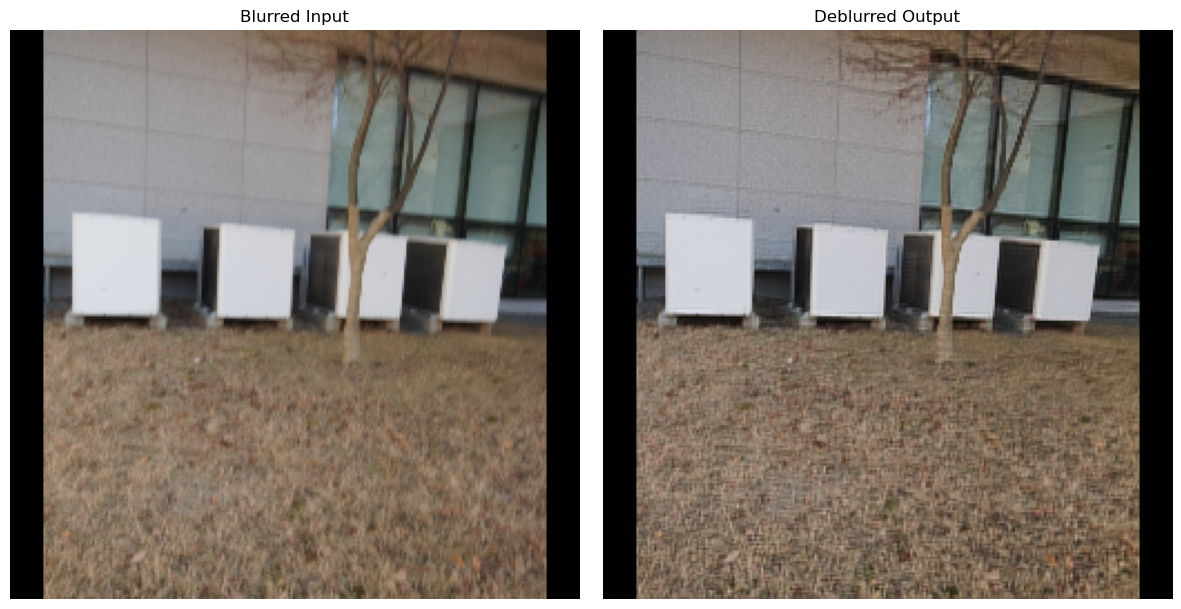

In [32]:
def load_and_preprocess_image(image_path, max_size=256):
    # Read image
    img = tf.io.read_file(image_path)
    
    # Decode image
    img = tf.image.decode_png(img, channels=3)
    if img.shape[-1] == 4:  # Remove alpha channel if present
        img = img[:, :, :3]
    
    # Resize image with aspect ratio preservation
    height = tf.cast(tf.shape(img)[0], tf.float32)
    width = tf.cast(tf.shape(img)[1], tf.float32)
    
    # Determine scaling factor
    scale = max_size / tf.maximum(height, width)
    
    # Calculate new dimensions
    new_height = tf.cast(height * scale, tf.int32)
    new_width = tf.cast(width * scale, tf.int32)
    
    # Resize image
    img = tf.image.resize(img, [new_height, new_width], 
                          method=tf.image.ResizeMethod.BILINEAR)

    img = tf.image.resize_with_crop_or_pad(img, 256, 256)
    
    # Normalize to [0, 1]
    img = tf.cast(img, tf.float32) / 255.0
    
    # Add batch dimension
    img = tf.expand_dims(img, 0)
    
    return img, new_height, new_width

def deblur_image(image_path, max_size=256):
    # Load and preprocess the image
    img_tensor, height, width = load_and_preprocess_image(image_path, max_size)
    
    # Generate the deblurred image
    deblurred_tensor = New_Model.predict(img_tensor)
    
    # Convert tensors to numpy arrays and squeeze batch dimension
    original_img = tf.squeeze(img_tensor).numpy()
    deblurred_img = tf.squeeze(deblurred_tensor).numpy()
    
    # Clip values to valid range [0, 1]
    deblurred_img = np.clip(deblurred_img, 0, 1)
    print("Deblurred image min:", deblurred_img.min(), "max:", deblurred_img.max())
    
    # Show results if requested
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title('Blurred Input')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(deblurred_img)
    plt.title('Deblurred Output')
    plt.axis('off')
    
    # diff = np.abs(original_img - deblurred_img)
    # plt.subplot(1, 1, 1)
    # plt.imshow(diff)
    # plt.title("Difference Map")
    # plt.colorbar()
    
    plt.tight_layout()
    plt.show()

    return deblurred_img
    
# Example usage
blurry_image_path = r"C:\Users\HP\Documents\RealBlur\RealBlur-J\test\scene001\blur\blur_20.png"
deblurredIMG = deblur_image(blurry_image_path)

In [34]:
# Save deblurred image
save_path = r"C:\Users\HP\OneDrive\الصور\deblurred_blur_20.png"
plt.imsave(save_path, deblurredIMG)
print(f"Deblurred image saved to: {save_path}")

Deblurred image saved to: C:\Users\HP\OneDrive\الصور\deblurred_blur_20.png
